In [4]:
import sys
import pickle
import uproot
sys.path.insert(1, r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\tracking')
sys.path.insert(1, r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\utils')
from parameters import *
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    #'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{amssymb}', r'\usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [14]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\geant4\data_phaseSpaceScan.root'

# branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
#                'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec',
#                'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
# with uproot.open(file_path) as tree:
#         hits_dict = tree['events'].arrays(branch_list, library="np")
# df_hits = pd.DataFrame.from_dict(hits_dict)

branch_list_detector = ['E', 'pdg', 'EcalEdep', 'layerID', 'barID', 'Nhits', 'Edep_e', 'Edep_mu']
branch_list_run = ['E', 'Edep', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
branch_list_electrons = ['E_e', 'Vertex_E', 'muID']
with uproot.open(file_path) as tree:
        detector_dict = tree['detector'].arrays(branch_list_detector, library="np")
        run_dict = tree['run'].arrays(branch_list_run, library="np")
        electrons_dict = tree['electrons'].arrays(branch_list_electrons, library="np")

df_detector = pd.DataFrame.from_dict(detector_dict)
df_run = pd.DataFrame.from_dict(run_dict)
df_electrons = pd.DataFrame.from_dict(electrons_dict)
df = pd.concat([df_run, df_detector, df_electrons], axis=1)

FileNotFoundError: file not found

    'C:\\Users\\kimyk\\OneDrive\\Bureau\\Master 1\\Projet_LPHE_I\\ecal_reco\\geant4\\data_phaseSpaceScan.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [ ]:
def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i]] for i in range(len(row['barID'])) if row['EcalEdep'][i] > 0]

def create_tracks(df, plot=False):
    tracks = []
    true_parameters = []
    good_angles_x = []
    bad_angles_x = []
    good_angles_y = []
    bad_angles_y = []
    total_good = 0
    total_bad = 0
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        layers = row['layerID']
        bars = row['barID']
        Edep = row['EcalEdep']
        hits = get_hits(row)
        hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 1]
        hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 0]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D()
            track.x = Track(hitsX)
            track.y = Track(hitsY)
            tracks.append(track)
            # row['y0'] - (thickness + thickness_screen) * row['ty']
            true_parameters.append([row['x0'], row['y0'] - (thickness + thickness + thickness_screen) * row['ty'], row['tx'], row['ty']])
            if track.is_good_2D_fit():
                good_angles_x.append(row['tx'])
                good_angles_y.append(row['ty'])
                total_good += 1
            else:
                bad_angles_x.append(row['tx'])
                bad_angles_y.append(row['ty'])
                total_bad += 1


    return tracks, true_parameters, good_angles_x, good_angles_y, bad_angles_x, bad_angles_y, total_bad, total_good


In [ ]:
tracks, true_parameters, good_angles_x, good_angles_y, bad_angles_x, bad_angles_y, total_bad, total_good = create_tracks(df)


NameError: name 'df' is not defined

In [ ]:
# testing individual outputs
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
true = true_parameters[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
print('Real parameters:  x0 = {:.2f}, y0 = {:.2f}, t_x = {:.2f}, t_y = {:.2f}'.format(true[0], true[1], true[2], true[3]))
print('Fit parameters:  x0 = {:.2f}, y0 = {:.2f}, t_x = {:.2f}, t_y = {:.2f}'.format(t.x.x0, t.y.x0, t.x.t, t.y.t))
print('chi2_x = {:.2f}, chi2_y = {:.2f}'.format(t.x.reduced_chi2, t.y.reduced_chi2))
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)
fig1.set_figheight(3)
fig1.set_figwidth(8)
fig2.set_figheight(3)
fig2.set_figwidth(8)
z = np.linspace(0, 16)
x = t.x.t*z+t.x.x0
y = t.y.t*z+t.y.x0
axs1.plot(x, z, 'b-')
axs2.plot(y, z, 'b-')
# fig1.savefig('../../../figs/example_good_track_bad_chi2.pdf')
# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# t.x.print(True, axs[0])
# t.y.print(True, axs[1])


NameError: name 'tracks' is not defined

In [ ]:
# fig1.savefig('../../../figs/example_good_track_bad_chi2.pdf')

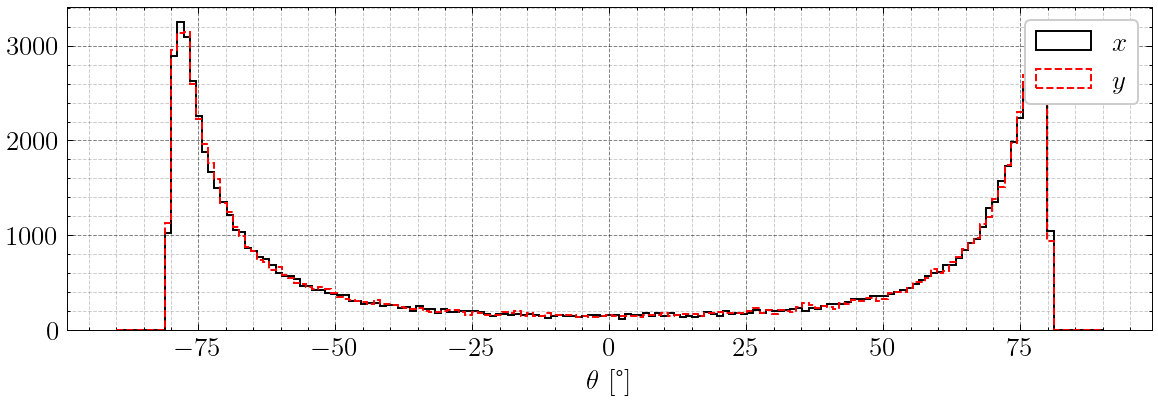

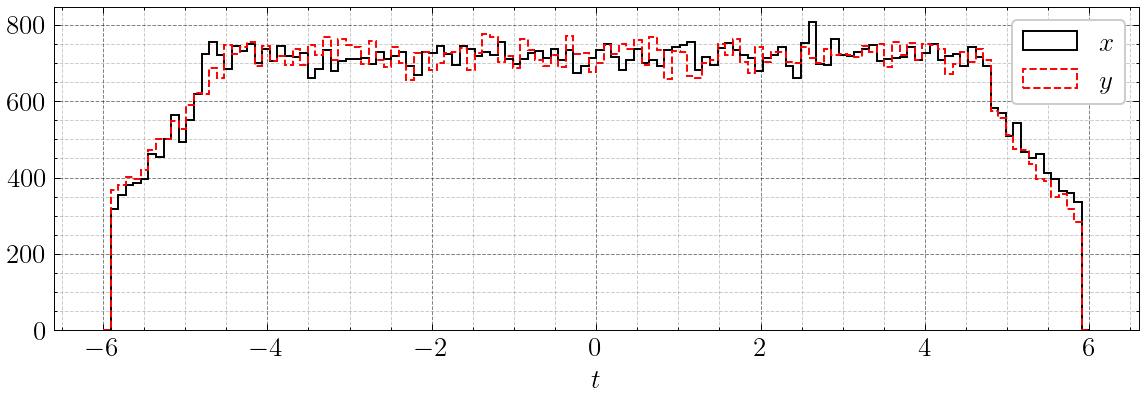

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(180 * np.arctan(np.array([tp[2] for tp in true_parameters])) / np.pi, bins = 161, range = [-90, 90], histtype = 'step', label = '$x$')
plt.hist(180 * np.arctan(np.array([tp[3] for tp in true_parameters])) / np.pi, bins=161, range = [-90, 90], histtype = 'step', label = '$y$')
plt.xlabel(r'$\theta$ [°]')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.legend()

plt.figure(figsize=(10,3))
n_x, t_x, _ = plt.hist(np.array([tp[2] for tp in true_parameters]), bins = 130, range = [-6, 6], histtype = 'step', label = '$x$')
n_y, t_y, _ = plt.hist(np.array([tp[3] for tp in true_parameters]), bins=130, range = [-6, 6], histtype = 'step', label = '$y$')
plt.xlabel(r'$t$')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.legend()


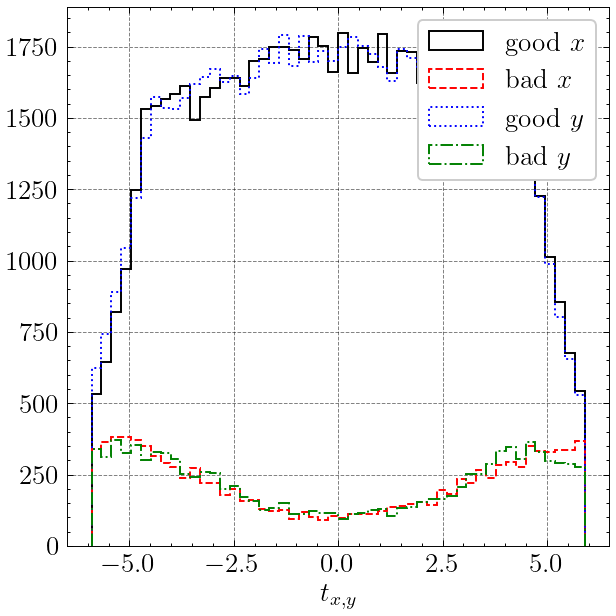

In [ ]:
plt.figure(figsize=(5,5))
n_goodx, t_goodx, _ = plt.hist(good_angles_x, bins = 50, histtype='step', label = 'good $x$')
n_badx, t_badx, _ = plt.hist(bad_angles_x, bins = 50, histtype='step', label = 'bad $x$')
n_goody, t_goody, _ = plt.hist(good_angles_y, bins = 50, histtype='step', label = 'good $y$')
n_bady, t_bady, _ = plt.hist(bad_angles_y, bins = 50, histtype='step', label = 'bad $y$')
plt.legend()
plt.xlabel('$t_{x,y}$')
plt.savefig('../../../figs/good_bad_tracks.pdf')

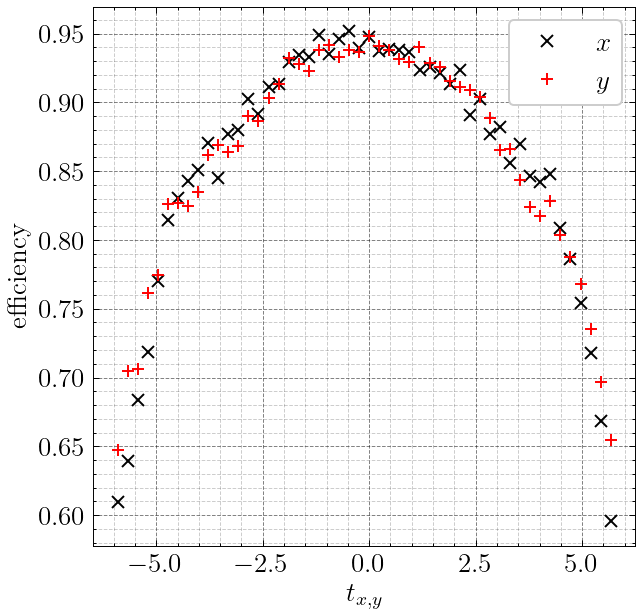

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(t_goodx[:-1], n_goodx/(n_goodx + n_badx), 'x', label = '$x$')
plt.plot(t_goody[:-1], n_goody/(n_goody + n_bady), '+', label = '$y$')
plt.legend()
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.xlabel('$t_{x,y}$')
plt.ylabel('efficiency')
plt.savefig('../../../figs/efficiency.pdf')

In [ ]:
with open('data_acceptance_x.pkl', 'wb') as outp:
    pickle.dump([t_goodx, t_badx, n_goodx, n_badx], outp, pickle.HIGHEST_PROTOCOL)
with open('data_acceptance_y.pkl', 'wb') as outp:
    pickle.dump([t_goody, t_bady, n_goody, n_bady], outp, pickle.HIGHEST_PROTOCOL)
